In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
def load_data(noise_u, noise_f):
    data = sio.loadmat("../dataset/kdv_train.mat")
    x_u_train, t_u_train = data["x_u_train"], data["t_u_train"]
    x_f_train, t_f_train = data["x_f_train"], data["t_f_train"]
    x_test, t_test, u_test = data["x_test"], data["t_test"], data["u_test"]
    x_test, t_test, u_test = (
        x_test.reshape([-1, 1]),
        t_test.reshape([-1, 1]),
        u_test.reshape([-1, 1]),
    )
    u_train, f_train = data["u_train"], data["f_train"]
    train_u = x_u_train, t_u_train, u_train
    train_f = x_f_train, t_f_train, f_train
    test = x_test, t_test, u_test
    return train_u, train_f, test

### Defining the PDE:


In [3]:
def pde_fn(x, u, k_1, k_2):
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    u_xxx = tf.gradients(u_xx, x)[0][..., 0:1]
    f = u_t - tf.exp(k_1) * u * u_x - tf.exp(k_2) * u_xxx
    # tf.exp(k_1) Computes exponential of k_1 element-wise (y = e^{k_1})
    return f

In [4]:
@neuq.utils.timer
def Samplable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_logk_2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1, process_logk_2],
        pde=pde_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1, process_logk_2],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=500,
        num_burnin=3000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=66,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_logk_1, process_logk_2]
    return processes, samples, model


In [5]:
@neuq.utils.timer
def Trainable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_logk_2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    # build losses
    loss_u = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1, process_logk_2],
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1, process_logk_2],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_logk_1, process_logk_2]
    return processes, samples, model

In [6]:
def plots(
    logk_1_pred,
    logk_2_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
):
    k_1_pred, k_2_pred = np.exp(logk_1_pred), np.exp(logk_2_pred)
    print("Mean & Std of k1 are %.3f, %.3f" % (np.mean(k_1_pred), np.std(k_1_pred)))
    print("Mean & Std of k2 are %.3f, %.3f" % (np.mean(k_2_pred), np.std(k_2_pred)))

    u_pred = np.reshape(u_pred, [-1, NT, NX])
    mu = np.mean(u_pred, axis=0)
    std = np.std(u_pred, axis=0)

    x_test = np.reshape(x_test, [NT, NX])
    t_test = np.reshape(t_test, [NT, NX])
    u_test = np.reshape(u_test, [NT, NX])
    i = 15

    current_t = t_test[i][0]
    current_x = x_u_train[t_u_train == current_t]
    current_u = u_train[t_u_train == current_t]
    # std = np.sqrt(std**2 + 0.1**2)
    plt.plot(np.linspace(-10, 10, 201), mu[i, :], "--", label="mean")
    plt.fill_between(
        np.linspace(-10, 10, 201), (mu + 2 * std)[i, :], (mu - 2 * std)[i, :], alpha=0.3
    )
    plt.plot(np.linspace(-10, 10, 201), u_test[i, :], label="reference")
    plt.plot(current_x, current_u, "o", label="observations")
    plt.legend()
    plt.title("t=" + str(current_t))
    plt.show()

## Load data and specify some hyperparameters
Noise for the measurements on both u and f is assumed to be distributed as a Gaussian with zero mean and standard deviation = 0.1

In [7]:
################## Load data and specify some hyperparameters ####################
NT, NX = 31, 201
noise = 0.1
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test

layers = [2, 50, 50, 1]

In [8]:
############################### Choose framework #################################
processes, samples, model = Samplable(x_u_train, t_u_train, u_train, 
                                      x_f_train, t_f_train, f_train, noise, layers,)
    # processes, samples, model = Trainable(
    #     x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,
    # )
    


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.828 

Execution time for 'Samplable' function is: 332.760 s, 5.546 mins


In [9]:
################################# Predictions ####################################
u_pred, logk_1_pred, logk_2_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), 
                                                 samples, processes, pde_fn=None,)

Mean & Std of k1 are 1.419, 0.038
Mean & Std of k2 are 0.264, 0.008


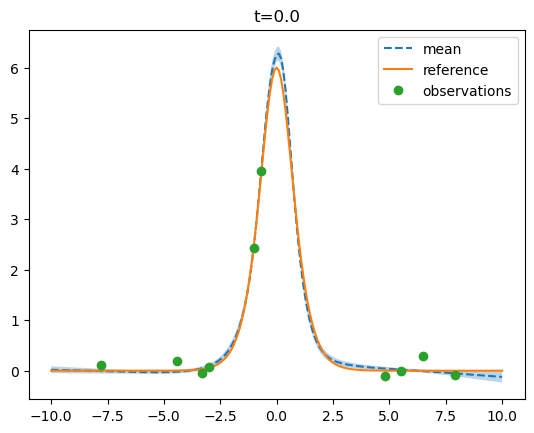

In [11]:
############################### Postprocessing ###################################
    # TODO: save the results, instead of visualizing them.
plots(
    logk_1_pred,
    logk_2_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

### Prove

In [12]:
NT, NX = 31, 201
noise = 0.3
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test

layers = [2, 50, 50, 1]



In [13]:
processes, samples, model = Samplable(x_u_train, t_u_train, u_train, 
                                      x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.778 

Execution time for 'Samplable' function is: 364.178 s, 6.070 mins


In [14]:
u_pred, logk_1_pred, logk_2_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), 
                                                 samples, processes, pde_fn=None,)

Mean & Std of k1 are 0.859, 0.065
Mean & Std of k2 are 0.191, 0.014


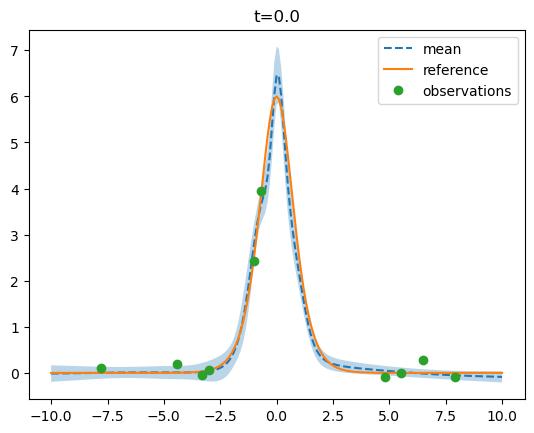

In [15]:
plots(
    logk_1_pred,
    logk_2_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

### Using DEns

In [8]:
processes, samples, model = Trainable(x_u_train, t_u_train, u_train, 
                                      x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  3.77563
Iteration:  100 , loss:  2.3946304
Iteration:  200 , loss:  1.8521
Iteration:  300 , loss:  1.4893435
Iteration:  400 , loss:  0.8568401
Iteration:  500 , loss:  0.43293336
Iteration:  600 , loss:  0.26609945
Iteration:  700 , loss:  0.18364173
Iteration:  800 , loss:  0.13955812
Iteration:  900 , loss:  0.1107081
Iteration:  1000 , loss:  0.09235907
Iteration:  1100 , loss:  0.07882629
Iteration:  1200 , loss:  0.06941541
Iteration:  1300 , loss:  0.063365586
Iteration:  1400 , loss:  0.05594806
Iteration:  1500 , loss:  0.050908823
Iteration:  1600 , loss:  0.047151256
Iteration:  1700 , loss:  0.04371331
Iteration:  1800 , loss:  0.041536573
Iteration:  1900 , loss:  0.038441796
Iteration:  2000 , loss:  0.03942822
Iteration:  2100 , loss:  0.034488164
Iteration:  2200 , loss:  0.03576564
Iteration:  2300 , loss:  0.031429872
Iteration:  2400

Iteration:  1300 , loss:  0.08055347
Iteration:  1400 , loss:  0.07098538
Iteration:  1500 , loss:  0.063379906
Iteration:  1600 , loss:  0.057178717
Iteration:  1700 , loss:  0.05175021
Iteration:  1800 , loss:  0.047251366
Iteration:  1900 , loss:  0.062498234
Iteration:  2000 , loss:  0.039930124
Iteration:  2100 , loss:  0.041132018
Iteration:  2200 , loss:  0.034502473
Iteration:  2300 , loss:  0.04459872
Iteration:  2400 , loss:  0.030383164
Iteration:  2500 , loss:  0.07800602
Iteration:  2600 , loss:  0.027196405
Iteration:  2700 , loss:  0.02580129
Iteration:  2800 , loss:  0.024726227
Iteration:  2900 , loss:  0.023611179
Iteration:  3000 , loss:  0.02286388
Iteration:  3100 , loss:  0.021936692
Iteration:  3200 , loss:  0.021378333
Iteration:  3300 , loss:  0.020610455
Iteration:  3400 , loss:  0.031832036
Iteration:  3500 , loss:  0.019547565
Iteration:  3600 , loss:  0.01918626
Iteration:  3700 , loss:  0.018661689
Iteration:  3800 , loss:  0.018488219
Iteration:  3900 , l

Iteration:  2800 , loss:  0.029363317
Iteration:  2900 , loss:  0.022650367
Iteration:  3000 , loss:  0.021671219
Iteration:  3100 , loss:  0.021203062
Iteration:  3200 , loss:  0.020602338
Iteration:  3300 , loss:  0.01996607
Iteration:  3400 , loss:  0.019535253
Iteration:  3500 , loss:  0.019496804
Iteration:  3600 , loss:  0.01872354
Iteration:  3700 , loss:  0.018321067
Iteration:  3800 , loss:  0.018021068
Iteration:  3900 , loss:  0.01911777
Iteration:  4000 , loss:  0.017398717
Iteration:  4100 , loss:  0.017477263
Iteration:  4200 , loss:  0.01688078
Iteration:  4300 , loss:  0.019808045
Iteration:  4400 , loss:  0.016441716
Iteration:  4500 , loss:  0.016549354
Iteration:  4600 , loss:  0.0437242
Iteration:  4700 , loss:  0.015883401
Iteration:  4800 , loss:  0.016640663
Iteration:  4900 , loss:  0.01557439
Iteration:  5000 , loss:  0.0156567
Iteration:  5100 , loss:  0.015309242
Iteration:  5200 , loss:  0.01569486
Iteration:  5300 , loss:  0.030337356
Iteration:  5400 , los

Iteration:  4400 , loss:  0.018822813
Iteration:  4500 , loss:  0.01856485
Iteration:  4600 , loss:  0.01931085
Iteration:  4700 , loss:  0.018161181
Iteration:  4800 , loss:  0.0179553
Iteration:  4900 , loss:  0.01783847
Iteration:  5000 , loss:  0.017619567
Iteration:  5100 , loss:  0.021732707
Iteration:  5200 , loss:  0.017313497
Iteration:  5300 , loss:  0.046647415
Iteration:  5400 , loss:  0.017037096
Iteration:  5500 , loss:  0.017066594
Iteration:  5600 , loss:  0.016790707
Iteration:  5700 , loss:  0.016662018
Iteration:  5800 , loss:  0.016691912
Iteration:  5900 , loss:  0.016448695
Iteration:  6000 , loss:  0.016675955
Iteration:  6100 , loss:  0.016245665
Iteration:  6200 , loss:  0.016175626
Iteration:  6300 , loss:  0.01606734
Iteration:  6400 , loss:  0.016192451
Iteration:  6500 , loss:  0.015905418
Iteration:  6600 , loss:  0.023060672
Iteration:  6700 , loss:  0.01575702
Iteration:  6800 , loss:  0.015681334
Iteration:  6900 , loss:  0.015621081
Iteration:  7000 , 

Iteration:  6100 , loss:  0.018219449
Iteration:  6200 , loss:  0.018078905
Iteration:  6300 , loss:  0.017902851
Iteration:  6400 , loss:  0.017896233
Iteration:  6500 , loss:  0.01762246
Iteration:  6600 , loss:  0.017459765
Iteration:  6700 , loss:  0.017364638
Iteration:  6800 , loss:  0.017205885
Iteration:  6900 , loss:  0.017581038
Iteration:  7000 , loss:  0.016967539
Iteration:  7100 , loss:  0.017620657
Iteration:  7200 , loss:  0.016747762
Iteration:  7300 , loss:  0.016620273
Iteration:  7400 , loss:  0.016628139
Iteration:  7500 , loss:  0.016432125
Iteration:  7600 , loss:  0.016337609
Iteration:  7700 , loss:  0.016252682
Iteration:  7800 , loss:  0.016131863
Iteration:  7900 , loss:  0.016126638
Iteration:  8000 , loss:  0.01595655
Iteration:  8100 , loss:  0.016396143
Iteration:  8200 , loss:  0.015791474
Iteration:  8300 , loss:  0.02443796
Iteration:  8400 , loss:  0.015634503
Iteration:  8500 , loss:  0.015846714
Iteration:  8600 , loss:  0.015494239
Iteration:  870

Iteration:  7600 , loss:  0.0143903205
Iteration:  7700 , loss:  0.01461857
Iteration:  7800 , loss:  0.014304964
Iteration:  7900 , loss:  0.014238087
Iteration:  8000 , loss:  0.014857622
Iteration:  8100 , loss:  0.014154162
Iteration:  8200 , loss:  0.0140965255
Iteration:  8300 , loss:  0.014079895
Iteration:  8400 , loss:  0.0140108615
Iteration:  8500 , loss:  0.015008467
Iteration:  8600 , loss:  0.01393559
Iteration:  8700 , loss:  0.047212042
Iteration:  8800 , loss:  0.013871428
Iteration:  8900 , loss:  0.013826785
Iteration:  9000 , loss:  0.013853692
Iteration:  9100 , loss:  0.013775902
Iteration:  9200 , loss:  0.016081672
Iteration:  9300 , loss:  0.01373122
Iteration:  9400 , loss:  0.013691677
Iteration:  9500 , loss:  0.013755191
Iteration:  9600 , loss:  0.013651732
Iteration:  9700 , loss:  0.013620533
Iteration:  9800 , loss:  0.013620532
Iteration:  9900 , loss:  0.01357588
Iteration:  10000 , loss:  0.014057605
Iteration:  10100 , loss:  0.013548616
Iteration: 

Iteration:  9100 , loss:  0.013903583
Iteration:  9200 , loss:  0.013902229
Iteration:  9300 , loss:  0.013851442
Iteration:  9400 , loss:  0.019901995
Iteration:  9500 , loss:  0.013805989
Iteration:  9600 , loss:  0.013768217
Iteration:  9700 , loss:  0.013776708
Iteration:  9800 , loss:  0.013725431
Iteration:  9900 , loss:  0.013992773
Iteration:  10000 , loss:  0.013683112
Iteration:  10100 , loss:  0.029178888
Iteration:  10200 , loss:  0.013643438
Iteration:  10300 , loss:  0.013607963
Iteration:  10400 , loss:  0.013621989
Iteration:  10500 , loss:  0.01357062
Iteration:  10600 , loss:  0.014737617
Iteration:  10700 , loss:  0.01353428
Iteration:  10800 , loss:  0.013516217
Iteration:  10900 , loss:  0.0135058835
Iteration:  11000 , loss:  0.013467837
Iteration:  11100 , loss:  0.014397433
Iteration:  11200 , loss:  0.013436737
Iteration:  11300 , loss:  0.013408007
Iteration:  11400 , loss:  0.013411913
Iteration:  11500 , loss:  0.01337144
Iteration:  11600 , loss:  0.0135221

Iteration:  10600 , loss:  0.012860108
Iteration:  10700 , loss:  0.012836637
Iteration:  10800 , loss:  0.012757141
Iteration:  10900 , loss:  0.012893753
Iteration:  11000 , loss:  0.012671695
Iteration:  11100 , loss:  0.024418183
Iteration:  11200 , loss:  0.012584824
Iteration:  11300 , loss:  0.012548186
Iteration:  11400 , loss:  0.012516493
Iteration:  11500 , loss:  0.012450214
Iteration:  11600 , loss:  0.012533718
Iteration:  11700 , loss:  0.012384224
Iteration:  11800 , loss:  0.018095233
Iteration:  11900 , loss:  0.01231723
Iteration:  12000 , loss:  0.012262682
Iteration:  12100 , loss:  0.01226306
Iteration:  12200 , loss:  0.012204395
Iteration:  12300 , loss:  0.012661046
Iteration:  12400 , loss:  0.01217737
Iteration:  12500 , loss:  0.012124637
Iteration:  12600 , loss:  0.012135322
Iteration:  12700 , loss:  0.01207201
Iteration:  12800 , loss:  0.012026548
Iteration:  12900 , loss:  0.012022629
Iteration:  13000 , loss:  0.012502847
Iteration:  13100 , loss:  0.

Iteration:  12100 , loss:  0.014129729
Iteration:  12200 , loss:  0.013281465
Iteration:  12300 , loss:  0.01329657
Iteration:  12400 , loss:  0.013241028
Iteration:  12500 , loss:  0.013235653
Iteration:  12600 , loss:  0.01320442
Iteration:  12700 , loss:  0.013330447
Iteration:  12800 , loss:  0.013168777
Iteration:  12900 , loss:  0.041324824
Iteration:  13000 , loss:  0.013145877
Iteration:  13100 , loss:  0.013115965
Iteration:  13200 , loss:  0.013129353
Iteration:  13300 , loss:  0.013091694
Iteration:  13400 , loss:  0.014908126
Iteration:  13500 , loss:  0.013047887
Iteration:  13600 , loss:  0.0130425
Iteration:  13700 , loss:  0.014223104
Iteration:  13800 , loss:  0.012996207
Iteration:  13900 , loss:  0.013084188
Iteration:  14000 , loss:  0.013259517
Iteration:  14100 , loss:  0.012978607
Iteration:  14200 , loss:  0.012938
Iteration:  14300 , loss:  0.014867967
Iteration:  14400 , loss:  0.0129622985
Iteration:  14500 , loss:  0.012887216
Iteration:  14600 , loss:  0.01

Iteration:  13600 , loss:  0.012783751
Iteration:  13700 , loss:  0.03049939
Iteration:  13800 , loss:  0.012747489
Iteration:  13900 , loss:  0.012716012
Iteration:  14000 , loss:  0.012719068
Iteration:  14100 , loss:  0.012678559
Iteration:  14200 , loss:  0.012747827
Iteration:  14300 , loss:  0.012643179
Iteration:  14400 , loss:  0.017851641
Iteration:  14500 , loss:  0.012608014
Iteration:  14600 , loss:  0.012583095
Iteration:  14700 , loss:  0.012585444
Iteration:  14800 , loss:  0.012552535
Iteration:  14900 , loss:  0.015338983
Iteration:  15000 , loss:  0.012522774
Iteration:  15100 , loss:  0.012500935
Iteration:  15200 , loss:  0.012496317
Iteration:  15300 , loss:  0.012464098
Iteration:  15400 , loss:  0.012469554
Iteration:  15500 , loss:  0.012434635
Iteration:  15600 , loss:  0.012511109
Iteration:  15700 , loss:  0.0124026425
Iteration:  15800 , loss:  0.012436291
Iteration:  15900 , loss:  0.012372177
Iteration:  16000 , loss:  0.012417704
Iteration:  16100 , loss:

Iteration:  15000 , loss:  0.013564998
Iteration:  15100 , loss:  0.017020335
Iteration:  15200 , loss:  0.0135392565
Iteration:  15300 , loss:  0.013509799
Iteration:  15400 , loss:  0.01353256
Iteration:  15500 , loss:  0.013484182
Iteration:  15600 , loss:  0.014848737
Iteration:  15700 , loss:  0.013459509
Iteration:  15800 , loss:  0.013847008
Iteration:  15900 , loss:  0.013436157
Iteration:  16000 , loss:  0.013402719
Iteration:  16100 , loss:  0.013454426
Iteration:  16200 , loss:  0.013377206
Iteration:  16300 , loss:  0.013752349
Iteration:  16400 , loss:  0.013355473
Iteration:  16500 , loss:  0.013328229
Iteration:  16600 , loss:  0.013372945
Iteration:  16700 , loss:  0.013308128
Iteration:  16800 , loss:  0.039657705
Iteration:  16900 , loss:  0.013286425
Iteration:  17000 , loss:  0.013300847
Iteration:  17100 , loss:  0.013268489
Iteration:  17200 , loss:  0.013234558
Iteration:  17300 , loss:  0.013284927
Iteration:  17400 , loss:  0.013210908
Iteration:  17500 , loss:

Iteration:  16700 , loss:  0.012458753
Iteration:  16800 , loss:  0.0127488095
Iteration:  16900 , loss:  0.012429837
Iteration:  17000 , loss:  0.01280264
Iteration:  17100 , loss:  0.012397308
Iteration:  17200 , loss:  0.0124326795
Iteration:  17300 , loss:  0.01237206
Iteration:  17400 , loss:  0.012637369
Iteration:  17500 , loss:  0.0123500265
Iteration:  17600 , loss:  0.012329886
Iteration:  17700 , loss:  0.0123215355
Iteration:  17800 , loss:  0.017554348
Iteration:  17900 , loss:  0.012288959
Iteration:  18000 , loss:  0.012285358
Iteration:  18100 , loss:  0.0123486705
Iteration:  18200 , loss:  0.012509889
Iteration:  18300 , loss:  0.012231323
Iteration:  18400 , loss:  0.012250183
Iteration:  18500 , loss:  0.012482313
Iteration:  18600 , loss:  0.012190048
Iteration:  18700 , loss:  0.012524489
Iteration:  18800 , loss:  0.012165606
Iteration:  18900 , loss:  0.01220679
Iteration:  19000 , loss:  0.013144977
Iteration:  19100 , loss:  0.0121217165
Iteration:  19200 , lo

Iteration:  18300 , loss:  0.011617585
Iteration:  18400 , loss:  0.01160439
Iteration:  18500 , loss:  0.012156774
Iteration:  18600 , loss:  0.011559195
Iteration:  18700 , loss:  0.014866378
Iteration:  18800 , loss:  0.011505034
Iteration:  18900 , loss:  0.011513936
Iteration:  19000 , loss:  0.011463221
Iteration:  19100 , loss:  0.011487342
Iteration:  19200 , loss:  0.011423492
Iteration:  19300 , loss:  0.01141167
Iteration:  19400 , loss:  0.012133032
Iteration:  19500 , loss:  0.011364695
Iteration:  19600 , loss:  0.0116511565
Iteration:  19700 , loss:  0.012148336
Iteration:  19800 , loss:  0.013124869
Iteration:  19900 , loss:  0.011286601
Generating 13th sample by deep ensemble...
Iteration:  0 , loss:  3.8234568
Iteration:  100 , loss:  2.4308324
Iteration:  200 , loss:  1.8800313
Iteration:  300 , loss:  1.5108838
Iteration:  400 , loss:  0.8046363
Iteration:  500 , loss:  0.3411052
Iteration:  600 , loss:  0.21291916
Iteration:  700 , loss:  0.15653722
Iteration:  800

Iteration:  19700 , loss:  0.011311319
Iteration:  19800 , loss:  0.011333713
Iteration:  19900 , loss:  0.011409648
Generating 14th sample by deep ensemble...
Iteration:  0 , loss:  3.609731
Iteration:  100 , loss:  2.2966828
Iteration:  200 , loss:  1.81075
Iteration:  300 , loss:  1.4136574
Iteration:  400 , loss:  0.81332475
Iteration:  500 , loss:  0.376015
Iteration:  600 , loss:  0.21204263
Iteration:  700 , loss:  0.14644505
Iteration:  800 , loss:  0.11286181
Iteration:  900 , loss:  0.0933285
Iteration:  1000 , loss:  0.07880995
Iteration:  1100 , loss:  0.07105072
Iteration:  1200 , loss:  0.06253808
Iteration:  1300 , loss:  0.058310285
Iteration:  1400 , loss:  0.054972805
Iteration:  1500 , loss:  0.049028307
Iteration:  1600 , loss:  0.04569254
Iteration:  1700 , loss:  0.042838406
Iteration:  1800 , loss:  0.04026606
Iteration:  1900 , loss:  0.0384591
Iteration:  2000 , loss:  0.036322255
Iteration:  2100 , loss:  0.034815356
Iteration:  2200 , loss:  0.03259229
Iterat

Iteration:  1000 , loss:  0.19428174
Iteration:  1100 , loss:  0.1593022
Iteration:  1200 , loss:  0.12832573
Iteration:  1300 , loss:  0.11056567
Iteration:  1400 , loss:  0.09989671
Iteration:  1500 , loss:  0.10299632
Iteration:  1600 , loss:  0.078614414
Iteration:  1700 , loss:  0.071179375
Iteration:  1800 , loss:  0.06503768
Iteration:  1900 , loss:  0.060694125
Iteration:  2000 , loss:  0.06501752
Iteration:  2100 , loss:  0.0517718
Iteration:  2200 , loss:  0.048956074
Iteration:  2300 , loss:  0.045719456
Iteration:  2400 , loss:  0.043449756
Iteration:  2500 , loss:  0.041013032
Iteration:  2600 , loss:  0.038931753
Iteration:  2700 , loss:  0.03720069
Iteration:  2800 , loss:  0.035457112
Iteration:  2900 , loss:  0.034039512
Iteration:  3000 , loss:  0.03261835
Iteration:  3100 , loss:  0.031560965
Iteration:  3200 , loss:  0.030354114
Iteration:  3300 , loss:  0.03217444
Iteration:  3400 , loss:  0.02842877
Iteration:  3500 , loss:  0.03305043
Iteration:  3600 , loss:  0.

Iteration:  2700 , loss:  0.025005382
Iteration:  2800 , loss:  0.02410444
Iteration:  2900 , loss:  0.024995968
Iteration:  3000 , loss:  0.022656132
Iteration:  3100 , loss:  0.021984307
Iteration:  3200 , loss:  0.021456376
Iteration:  3300 , loss:  0.020875901
Iteration:  3400 , loss:  0.02048283
Iteration:  3500 , loss:  0.019954113
Iteration:  3600 , loss:  0.01993752
Iteration:  3700 , loss:  0.019195989
Iteration:  3800 , loss:  0.019800304
Iteration:  3900 , loss:  0.018659452
Iteration:  4000 , loss:  0.018312031
Iteration:  4100 , loss:  0.018771745
Iteration:  4200 , loss:  0.017769953
Iteration:  4300 , loss:  0.03075061
Iteration:  4400 , loss:  0.01734915
Iteration:  4500 , loss:  0.017135253
Iteration:  4600 , loss:  0.016997663
Iteration:  4700 , loss:  0.016786736
Iteration:  4800 , loss:  0.01673742
Iteration:  4900 , loss:  0.016489098
Iteration:  5000 , loss:  0.016344782
Iteration:  5100 , loss:  0.016223958
Iteration:  5200 , loss:  0.016073905
Iteration:  5300 ,

Iteration:  4100 , loss:  0.018266428
Iteration:  4200 , loss:  0.018063232
Iteration:  4300 , loss:  0.018185819
Iteration:  4400 , loss:  0.017771356
Iteration:  4500 , loss:  0.017620925
Iteration:  4600 , loss:  0.017523771
Iteration:  4700 , loss:  0.017365746
Iteration:  4800 , loss:  0.018953465
Iteration:  4900 , loss:  0.017154843
Iteration:  5000 , loss:  0.017028507
Iteration:  5100 , loss:  0.016978387
Iteration:  5200 , loss:  0.01684013
Iteration:  5300 , loss:  0.016803103
Iteration:  5400 , loss:  0.016672563
Iteration:  5500 , loss:  0.018160528
Iteration:  5600 , loss:  0.016515361
Iteration:  5700 , loss:  0.02500832
Iteration:  5800 , loss:  0.016373726
Iteration:  5900 , loss:  0.016281575
Iteration:  6000 , loss:  0.016248286
Iteration:  6100 , loss:  0.016151119
Iteration:  6200 , loss:  0.01618679
Iteration:  6300 , loss:  0.01603685
Iteration:  6400 , loss:  0.017700689
Iteration:  6500 , loss:  0.015933933
Iteration:  6600 , loss:  0.015856702
Iteration:  6700

Iteration:  5700 , loss:  0.016058931
Iteration:  5800 , loss:  0.015008982
Iteration:  5900 , loss:  0.026722776
Iteration:  6000 , loss:  0.014848068
Iteration:  6100 , loss:  0.014741201
Iteration:  6200 , loss:  0.014737451
Iteration:  6300 , loss:  0.014601608
Iteration:  6400 , loss:  0.018495101
Iteration:  6500 , loss:  0.014475724
Iteration:  6600 , loss:  0.04478153
Iteration:  6700 , loss:  0.014363025
Iteration:  6800 , loss:  0.014292993
Iteration:  6900 , loss:  0.014279606
Iteration:  7000 , loss:  0.0141978
Iteration:  7100 , loss:  0.015418267
Iteration:  7200 , loss:  0.01411251
Iteration:  7300 , loss:  0.014487782
Iteration:  7400 , loss:  0.014040454
Iteration:  7500 , loss:  0.01397383
Iteration:  7600 , loss:  0.014460599
Iteration:  7700 , loss:  0.013906224
Iteration:  7800 , loss:  0.013847976
Iteration:  7900 , loss:  0.013866481
Iteration:  8000 , loss:  0.013797285
Iteration:  8100 , loss:  0.013743414
Iteration:  8200 , loss:  0.013768601
Iteration:  8300 

Iteration:  7200 , loss:  0.015309487
Iteration:  7300 , loss:  0.01525708
Iteration:  7400 , loss:  0.015219556
Iteration:  7500 , loss:  0.0151382815
Iteration:  7600 , loss:  0.0152850095
Iteration:  7700 , loss:  0.015039195
Iteration:  7800 , loss:  0.014976362
Iteration:  7900 , loss:  0.014959408
Iteration:  8000 , loss:  0.014891927
Iteration:  8100 , loss:  0.017443547
Iteration:  8200 , loss:  0.014809785
Iteration:  8300 , loss:  0.03736512
Iteration:  8400 , loss:  0.014733597
Iteration:  8500 , loss:  0.0147046335
Iteration:  8600 , loss:  0.014667729
Iteration:  8700 , loss:  0.014617804
Iteration:  8800 , loss:  0.014732528
Iteration:  8900 , loss:  0.014556955
Iteration:  9000 , loss:  0.04525865
Iteration:  9100 , loss:  0.014503401
Iteration:  9200 , loss:  0.014462518
Iteration:  9300 , loss:  0.014605549
Iteration:  9400 , loss:  0.014411472
Iteration:  9500 , loss:  0.030621115
Iteration:  9600 , loss:  0.014362238
Iteration:  9700 , loss:  0.014326694
Iteration:  

In [9]:
################################# Predictions ####################################
u_pred, logk_1_pred, logk_2_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), 
                                                 samples, processes, pde_fn=None,)

Mean & Std of k1 are 1.616, 0.068
Mean & Std of k2 are 0.348, 0.039


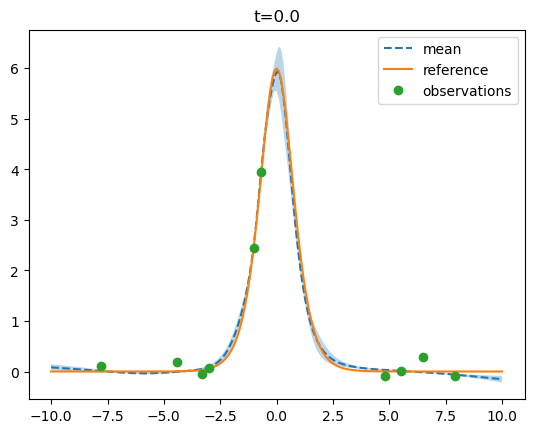

In [10]:
############################### Postprocessing ###################################
    # TODO: save the results, instead of visualizing them.
plots(
    logk_1_pred,
    logk_2_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

### Prova con un'altra equazione

In [ ]:
def pde_fn(x, u, k_1, k_2):
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    u_xxx = tf.gradients(u_xx, x)[0][..., 0:1]
    f = u_t - tf.exp(k_1) * u * u_x - tf.exp(k_2) * u_xxx
    # tf.exp(k_1) Computes exponential of k_1 element-wise (y = e^{k_1})
    return f